In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
#%tensorflow_version 2.1
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()

print(tf.__version__)
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32*32*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 32, 256)))
    #assert model.output_shape == (None, 32, 32, 64) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #assert model.output_shape == (None, 32, 32, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #assert model.output_shape == (None, 128, 128, 3)

    return model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - 1e-5, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + 1e-5, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#Define the training loop
EPOCHS = 500000000
noise_dim = 100
num_examples_to_generate = 9
BUFFER_SIZE = 35000
BATCH_SIZE = 256



def checkAccuracy(images):
      generated_images = generator(noise, training=False)
      #np.reshape(images,[1,128,128,3])
      #real_output = discriminator(images, training=False)
      #print('real_output : ' + str(real_output))

      fake_output = discriminator(generated_images, training=False)
      print('fake_output : ' + str(fake_output))
      gen_loss = generator_loss(fake_output)
      print('generator loss: ' + str(gen_loss))
      #disc_loss = discriminator_loss(real_output, fake_output)
      #print('discriminator_loss : ' + str(disc_loss))

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    print('train_step')

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      #np.reshape(images,[1,128,128,3])
      real_output = discriminator(images, training=True)

      fake_output = discriminator(generated_images, training=True)
      print('gen  loss: ' + str(fake_output))
      gen_loss = generator_loss(fake_output)
      print('generator loss: ' + str(gen_loss))
      disc_loss = discriminator_loss(real_output, fake_output)

      print('discriminator_loss : ' + str(disc_loss))


    print('setting grads')
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    print('apply variables')

def train(dataset, epochs):
  print('calling train')
  
  for epoch in range(epochs):
    start = time.time()
    #display.clear_output(wait=True)
    for image_batch in dataset:
      train_step(image_batch)


    # Produce images for the GIF as we go
    #generate_and_save_images(generator,
                             #epoch + 1,
                             #seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    generate_and_save_images(generator,
                           epoch,
                           seed) 
    if (epoch + 1) % 10 == 0:   
      display.clear_output(wait=True)
      ran = tf.random.normal([num_examples_to_generate, noise_dim])
      predictions = generator(ran,training=False)
      fig = plt.figure(figsize=(16,16))
      for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img = np.array(predictions[i] * 127.5 + 127.5)
        plt.imshow(img.astype(int))
        plt.axis('off')
      plt.show()
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    checkAccuracy(train_images[:1000])
    
  # Generate after the final epoch
  #display.clear_output(wait=True)
  #if epoch % 30 == 0:
  
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.22
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(16,16))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img = np.array(predictions[i] * 127.5 + 127.5)
      plt.imshow(img.astype(int))
      plt.axis('off')
  if epoch % 50 == 0:
    plt.savefig('colabDrive/My Drive/Colab Notebooks/large_files/birds_generated_images/norm/image_at__epoch_{:04d}.png'.format(epoch))
  #plt.imshow(predictions[-1])
  #plt.savefig('colabDrive/My Drive/Colab Notebooks/large_files/birds_generated_images/single/image_at__epoch_{:04d}.png'.format(epoch))
  plt.show()

2.2.0-rc3


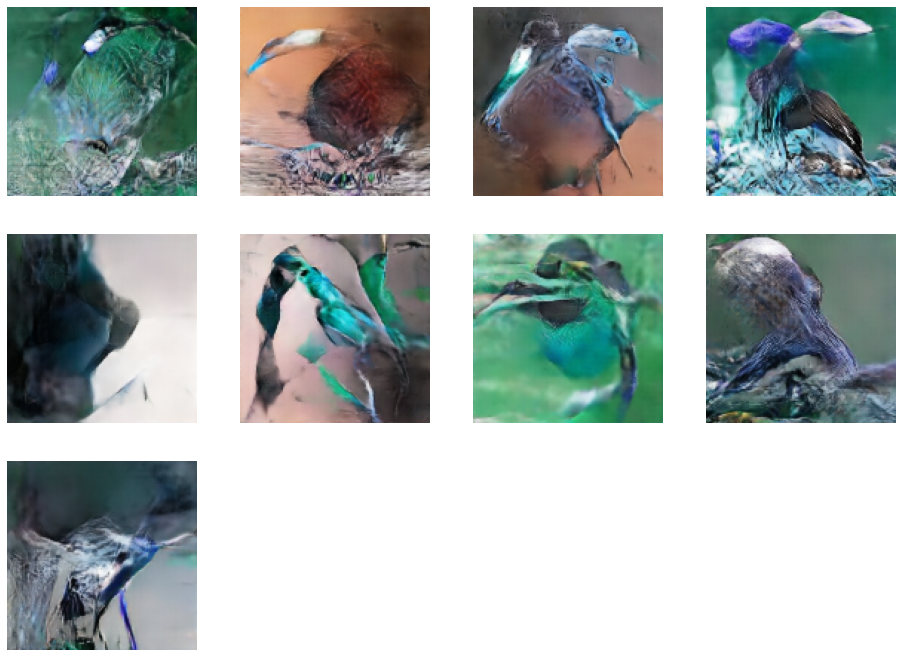

Time for epoch 10 is 39.48684763908386 sec
fake_output : tf.Tensor([[-1.7496678]], shape=(1, 1), dtype=float32)
generator loss: tf.Tensor(1.9099411, shape=(), dtype=float32)


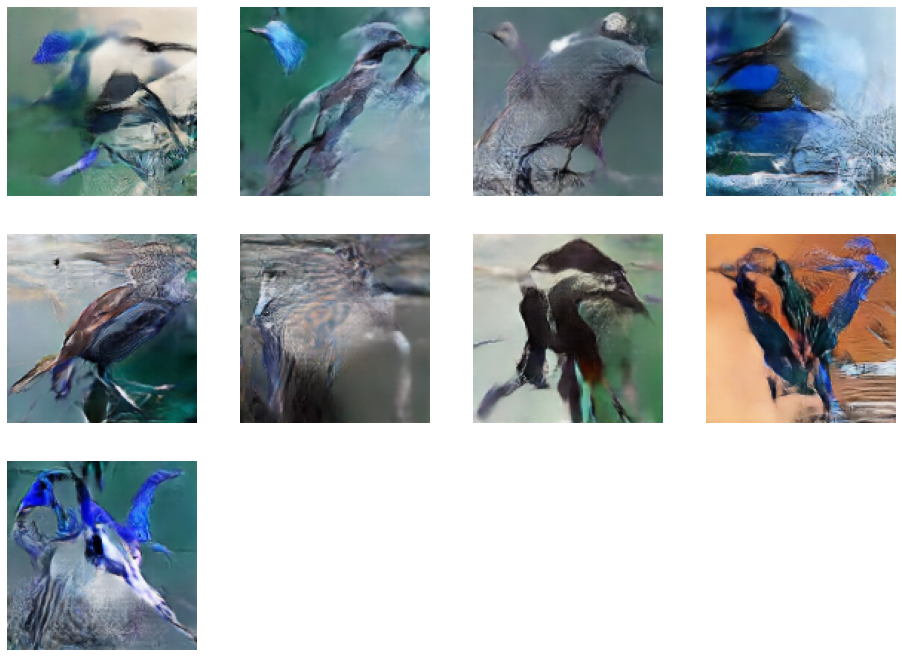

Time for epoch 11 is 36.43102669715881 sec
fake_output : tf.Tensor([[-1.8885003]], shape=(1, 1), dtype=float32)
generator loss: tf.Tensor(2.0293908, shape=(), dtype=float32)


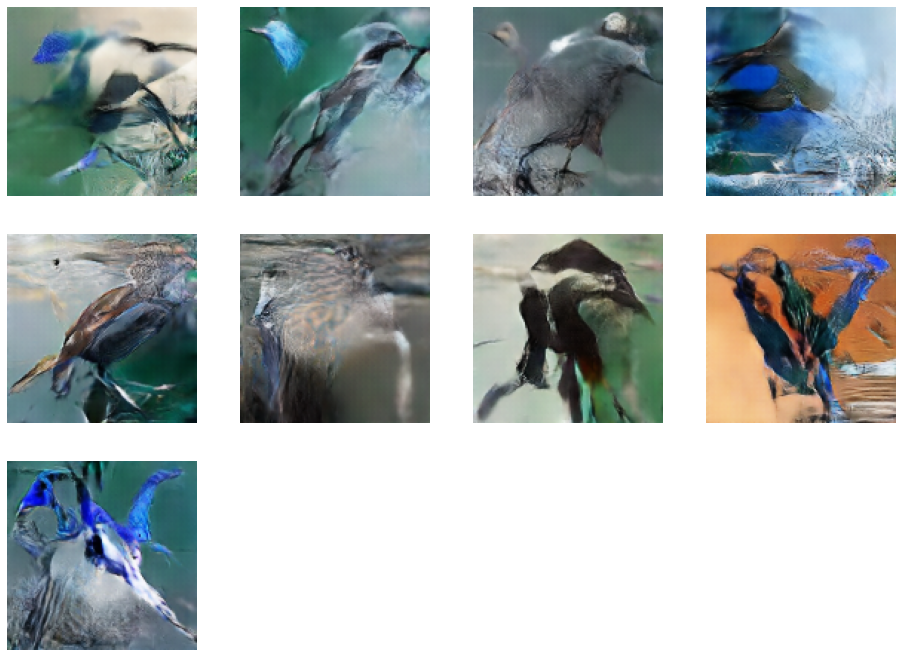

Time for epoch 12 is 36.44478225708008 sec
fake_output : tf.Tensor([[-1.9135578]], shape=(1, 1), dtype=float32)
generator loss: tf.Tensor(2.0511909, shape=(), dtype=float32)


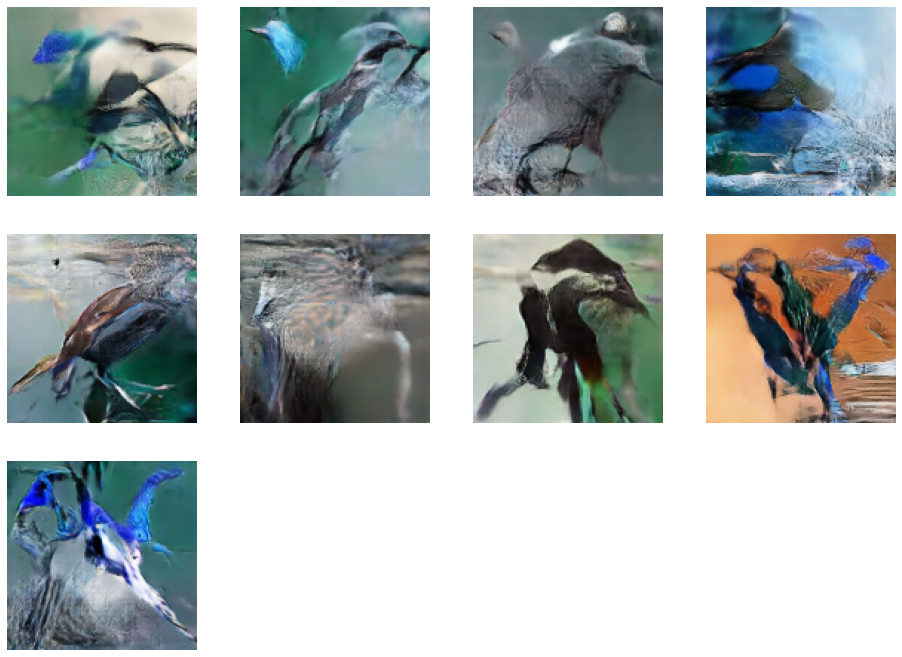

Time for epoch 13 is 36.524426221847534 sec
fake_output : tf.Tensor([[-3.3045373]], shape=(1, 1), dtype=float32)
generator loss: tf.Tensor(3.3405955, shape=(), dtype=float32)


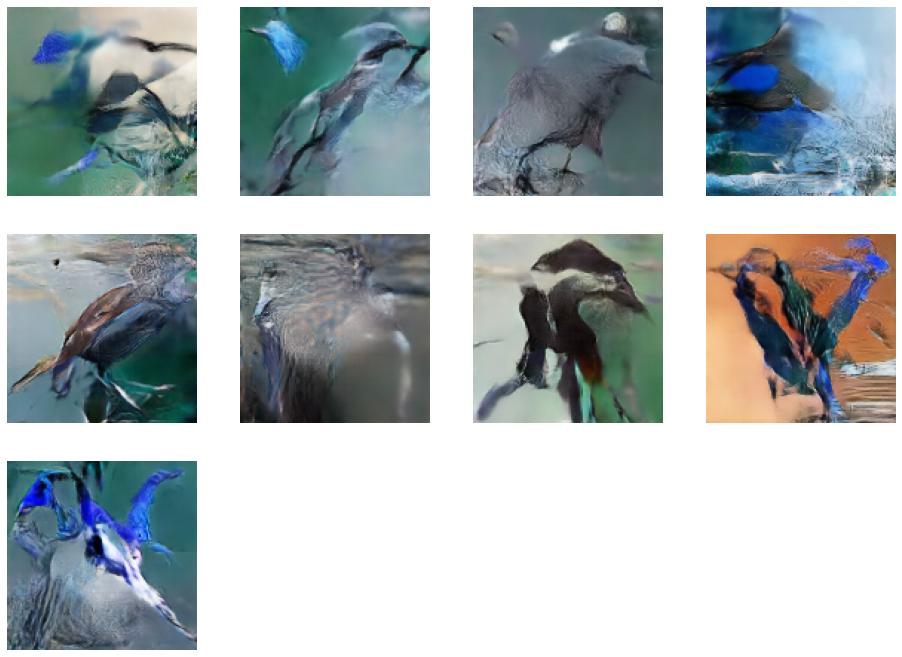

Time for epoch 14 is 36.40482974052429 sec
fake_output : tf.Tensor([[-2.5998583]], shape=(1, 1), dtype=float32)
generator loss: tf.Tensor(2.6715128, shape=(), dtype=float32)


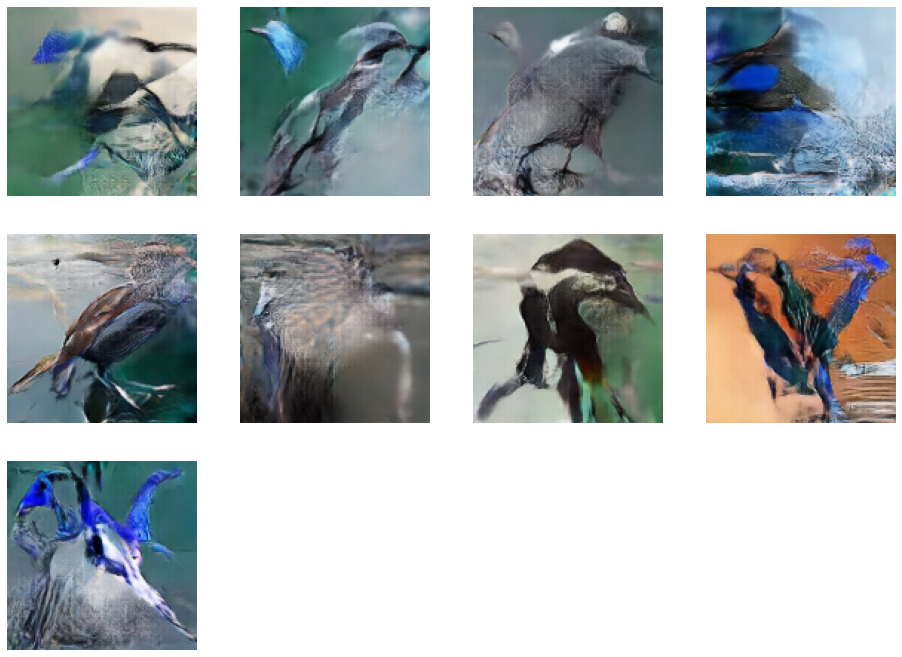

Time for epoch 15 is 36.393776416778564 sec
fake_output : tf.Tensor([[-2.1611476]], shape=(1, 1), dtype=float32)
generator loss: tf.Tensor(2.270175, shape=(), dtype=float32)


KeyboardInterrupt: ignored

In [0]:


generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0])

from google.colab import drive
#drive.mount._DEBUG = True
drive.mount('colabDrive', force_remount=False)

discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
checkpoint_dir = 'colabDrive/My Drive/Colab Notebooks/large_files/training_checkpoints_3'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

train_images = np.load('colabDrive/My Drive/Colab Notebooks/large_files/birds2.npy')
print(len(train_images))
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

chk = checkpoint.restore(tf.train.latest_checkpoint('colabDrive/My Drive/Colab Notebooks/large_files/training_checkpoints_3'))
#chk.assert_existing_objects_matched()
train(train_dataset, EPOCHS)

In [2]:
!pip install --user bpe


     |████████████████████████████████| 21.7MB 1.7MB/s 
     |████████████████████████████████| 296kB 43.1MB/s 
     |████████████████████████████████| 747kB 48.8MB/s 
ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 3.7.4.2 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [6]:
!pip install bpe

from bpe import Encoder

# Generated with http://pythonpsum.com
test_corpus = '''
    Object raspberrypi functools dict kwargs. Gevent raspberrypi functools. Dunder raspberrypi decorator dict didn't lambda zip import pyramid, she lambda iterate?
    Kwargs raspberrypi diversity unit object gevent. Import fall integration decorator unit django yield functools twisted. Dunder integration decorator he she future. Python raspberrypi community pypy. Kwargs integration beautiful test reduce gil python closure. Gevent he integration generator fall test kwargs raise didn't visor he itertools...
    Reduce integration coroutine bdfl he python. Cython didn't integration while beautiful list python didn't nit!
    Object fall diversity 2to3 dunder script. Python fall for: integration exception dict kwargs dunder pycon. Import raspberrypi beautiful test import six web. Future integration mercurial self script web. Return raspberrypi community test she stable.
    Django raspberrypi mercurial unit import yield raspberrypi visual rocksdahouse. Dunder raspberrypi mercurial list reduce class test scipy helmet zip?
'''

encoder = Encoder(200, pct_bpe=0.88)  # params chosen for demonstration purposes
encoder.fit(test_corpus.split('\n'))

example = "Vizzini: He didn't fall? INCONCEIVABLE!"

ModuleNotFoundError: ignored